### Factors Driving Life Expectancy : Do immunization matters?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,  f_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import os

from library.sb_utils import save_file

In [2]:
sns.set()
sns.set_context("notebook")

### Import dataset 

In [3]:
df = pd.read_csv("../data/life_exp_clean_encod.csv")

In [4]:
df.head(2)

,Country,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,...,HIV/AIDS,GDP,Population,thinness__1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,population,Status_Developed,Status_Developing
0,Afghanistan,2015,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,...,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,17.334091,0,1
1,Afghanistan,2014,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,...,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,12.699494,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2928 non-null   object 
 1   Year                             2928 non-null   int64  
 2   Life_expectancy                  2928 non-null   float64
 3   Adult_Mortality                  2928 non-null   float64
 4   infant_deaths                    2090 non-null   float64
 5   Alcohol                          2735 non-null   float64
 6   percentage_expenditure           2322 non-null   float64
 7   Hepatitis_B                      2375 non-null   float64
 8   Measles                          1955 non-null   float64
 9   BMI                              2896 non-null   float64
 10  under_five_deaths                2153 non-null   float64
 11  Polio                            2909 non-null   float64
 12  Total_expenditure   

In [6]:
df = df.drop(columns='Country')

In [7]:
# define X and y
X = df.drop(columns='Life_expectancy')
y = df.Life_expectancy

In [8]:
# split the dataset     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [9]:
X_train.shape, X_test.shape

((2049, 22), (879, 22))

In [10]:
# traitement of missing data with MICE Imputation
mice_imputer = IterativeImputer()
X_train_imput = mice_imputer.fit_transform(X_train)
X_test_imput = mice_imputer.transform(X_test)

In [11]:
# scale the date
scaler = StandardScaler()
X_train_imput_scale = scaler.fit_transform(X_train_imput)
X_test_imput_scale = scaler.transform(X_test_imput)

###  Modeling


##### Function to evaluate the model

In [12]:
def model_eval(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

### 1. Model     Simple linear_regression 

In [13]:
pipe = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [14]:
# define the k range to investigate
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [15]:
reg_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [16]:
reg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000207B801D940>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22]})

In [17]:
#Print the `best_params_` attribute of 'red_grid_cv`
reg_grid_cv.best_params_

{'selectkbest__k': 20}

In [18]:
score_mean = reg_grid_cv.cv_results_['mean_test_score']
score_std = reg_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in reg_grid_cv.cv_results_['param_selectkbest__k']]
best_k = reg_grid_cv.best_params_['selectkbest__k']

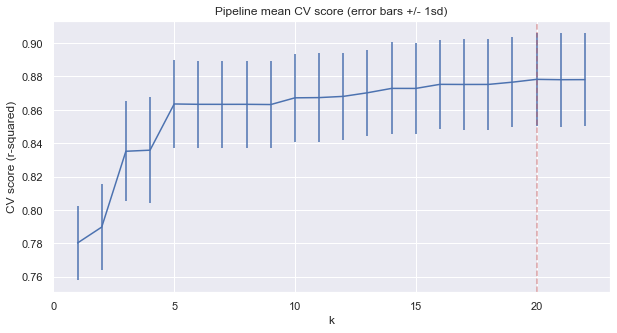

In [19]:
best_k = reg_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 20

In [20]:
# mask to select the most useful features 
selected_features= reg_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True])

In [21]:
coefs = reg_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected_features]
pd.Series(coefs, index=features).sort_values(ascending=False)

Income_composition_of_resources    7.427154
infant_deaths                      6.870449
percentage_expenditure             1.160588
Total_expenditure                  0.531725
Diphtheria                         0.315334
Polio                              0.279187
Status_Developed                   0.095960
Hepatitis_B                        0.083236
Year                               0.051710
thinness__1_19_years               0.035319
thinness_5_9_years                -0.064634
Measles                           -0.072705
Status_Developing                 -0.095960
BMI                               -0.096273
Alcohol                           -0.537031
Schooling                         -1.052180
GDP                               -1.096672
Adult_Mortality                   -1.621094
HIV/AIDS                          -1.868475
under_five_deaths                 -7.072457
dtype: float64

In [22]:
coef_features=pd.Series(coefs, index=features).sort_values(ascending=False)
coef_features = pd.DataFrame(coef_features)
coef_features.rename({0: 'coef_feature'}, inplace=True)

#### Note:
From this result, the best positive features here are Income_composition_of_resources , followed by infant_deaths. 

Features which negatively influence life expectancy are under_five_deaths of children (the most important) , next it is HIV/AIDS and Adult_Mortality.

We realise that immunization factors are also present among the positive features (come in 6th , 7th and 8th positions) even if their strength is not high as compared to the first features. 

It is also important to highlight the fact that the feature: status of the country (either developed or developing) has an impact on the model. 
May, it would be great to expect if a dataset with only developing countries would highlight the importance of immunization as we explore in the EDA.


In [23]:
reg_grid_cv.best_estimator_

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x00000207B801D940>)),
                ('linearregression', LinearRegression())])

In [24]:
lin_reg = reg_grid_cv.best_estimator_

#### Assess performance on train and test data

In [25]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4212886816126575
MSE: 11.085552729009013
RMSE: 3.3294973688244616
R2 Square 0.8761891643896423
__________________________________
MAE: 2.4352700808445658
MSE: 10.83356220337772
RMSE: 3.2914377106938724
R2 Square 0.8810966002170159
__________________________________


#### Assessing performance using cross-validation

In [26]:
cv_results = cross_validate(reg_grid_cv.best_estimator_, X_train, y_train, cv=5)

In [27]:
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.8793952573267643, 0.013289807859740158)

### 2. Model linear regression with PCA

In [28]:
pipe3 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    PCA(n_components=19),
    LinearRegression())

In [29]:
lin_reg2 = pipe3.fit(X_train, y_train)

#### Model Evaluation

In [30]:
predicted_train = lin_reg2.predict(X_train)
predicted_test = lin_reg2.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.6752494795922654
MSE: 12.880212033324813
RMSE: 3.588901229251763
R2 Square 0.8561452140756641
__________________________________
MAE: 2.7194090026780766
MSE: 12.856261215395348
RMSE: 3.5855628868275824
R2 Square 0.8588965348320963
__________________________________


### 3. Model: Ridge regression 

In [31]:
# Perform 5-fold cross-validation: ridge_cv
alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]
for x in alpha:
    ridge = Ridge(alpha=10)
    ridge_cv = cross_val_score(ridge, X_train_imput_scale, y_train, cv=10, n_jobs=-1)
    print( 'cross-validated scores of ridge regression for alpha', x ,'is :', np.mean(ridge_cv))

cross-validated scores of ridge regression for alpha 1e-05 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 0.0001 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 0.001 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 0.01 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 0.1 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 0.0 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 1.0 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 10.0 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 20.0 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 40.0 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 60.0 is : 0.8760049691832279
cross-validated scores of ridge regression for alpha 80.0 is : 0.8760049691832279
cross-validated

In [32]:
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 20.0, 40.0, 60.0, 80.0 ,100.0]

In [33]:
pipe4 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge())

In [34]:
ridge_grid_cv = GridSearchCV(pipe4, grid, cv=10, n_jobs=-1)

#####  Model: Ridge regression 

In [35]:
pipe5 = make_pipeline(
    IterativeImputer(), 
    StandardScaler(),
    Ridge(alpha=0.5))

In [36]:
ridge_reg = pipe5.fit(X_train, y_train)

In [37]:
predicted_train = ridge_reg.predict(X_train)
predicted_test = ridge_reg.predict(X_test)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.4195067949142457
MSE: 11.080545923950805
RMSE: 3.3287453978865376
R2 Square 0.8762450837229537
__________________________________
MAE: 2.4361589115632234
MSE: 10.830899453920331
RMSE: 3.291033189428562
R2 Square 0.8811258251346662
__________________________________


### 4.ElasticNet regression

In [38]:
#  hyperparameter grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1.1, 0.1)

In [39]:
grid

{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

###### identify the best parameters

In [40]:
elastic_net = ElasticNet()

EL_grid_cv0 = GridSearchCV(elastic_net, grid, cv=5, n_jobs=-1)

EL_grid_cv0 .fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11094.22160501179, tolerance: 18.668910220595414
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0,
                                   10.0, 100.0],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [41]:
print("Tuned ElasticNet l1 ratio: {}".format(EL_grid_cv0.best_params_))

Tuned ElasticNet l1 ratio: {'alpha': 0.0, 'l1_ratio': 0.0}


##### Run the model with the best paramters and assessing the performance

In [42]:
elastic_net = ElasticNet(alpha = 0.0, l1_ratio = 0.0)

elastic_net_CV = cross_val_score(elastic_net, X_train_imput_scale, y_train, cv=10, n_jobs=-1)

print( 'cross-validation scores of elastic_net regression is ', np.mean(elastic_net_CV))

cross-validation scores of elastic_net regression is  0.8777380250766889


In [43]:
Elastic_net = elastic_net.fit( X_train_imput_scale, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_11896/2293483320.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  Elastic_net = elastic_net.fit( X_train_imput_scale, y_train)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11094.22160501179, tolerance: 18.668910220595414
  model = cd_fast.enet_coordinate_descent(


In [44]:
predicted_train = Elastic_net.predict(X_train_imput_scale)
predicted_test = Elastic_net.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.420697486774153
MSE: 11.090841927784066
RMSE: 3.33029156798381
R2 Square 0.8761300910952332
__________________________________
MAE: 2.434864653945281
MSE: 10.828913230855823
RMSE: 3.2907314127494245
R2 Square 0.8811476248595087
__________________________________


### 5.  Decision tree for regression

In [45]:
param_rf={'max_depth':[4,6,8, 10, 12, 14, 16], 'min_samples_leaf': [0.1, 0.2, 0.5, 1, 1.5, 2], 
          'max_features': [0.2,0.4, 0.6, 0.8, 1.0]}

In [46]:
dt = DecisionTreeRegressor(random_state=1)
dt_grid_CV= GridSearchCV(estimator= dt ,param_grid=param_rf, cv=10,
                          scoring='accuracy',  n_jobs=-1)
# Fit dt to the training set
dt_grid_CV=dt_grid_CV.fit(X_train_imput_scale, y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warni

In [47]:
best_dt_param = dt_grid_CV.best_params_
best_dt_param

{'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 0.1}

In [48]:
model_dt = dt_grid_CV.best_estimator_

In [49]:
predicted_train = dt_grid_CV.predict(X_train_imput_scale)
predicted_test = dt_grid_CV.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 3.863532769202153
MSE: 27.570816497385476
RMSE: 5.250791987632482
R2 Square 0.6920707598035769
__________________________________
MAE: 3.8674476846519696
MSE: 27.097628249072212
RMSE: 5.205538228566976
R2 Square 0.7025908870615473
__________________________________


### 6.Random Forest Model

https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb

#### Simple model of random forest 

In [50]:
rf_reg1 = RandomForestRegressor(n_estimators = 200, max_depth= 4, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg1.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=4, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

##### evaluate the model

In [51]:
predicted_train = rf_reg1.predict(X_train_imput_scale)
predicted_test = rf_reg1.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 2.0700118418698006
MSE: 8.310518575927086
RMSE: 2.882797005674712
R2 Square 0.9071825939225935
__________________________________
MAE: 1.9656666833262233
MSE: 7.371327708600073
RMSE: 2.715018914961749
R2 Square 0.9190962391674096
__________________________________


#### 2nd model of random forest 

In [52]:
rf_reg2 = RandomForestRegressor(n_estimators = 200, max_depth= 10, max_features=0.4, n_jobs=-1, random_state=1)
rf_reg2.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=10, max_features=0.4, n_estimators=200,
                      n_jobs=-1, random_state=1)

In [53]:
# evaluate the model
predicted_train = rf_reg2.predict(X_train_imput_scale)
predicted_test = rf_reg2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.3513908643709975
MSE: 4.041962190934747
RMSE: 2.0104631782091276
R2 Square 0.9548566743942736
__________________________________
MAE: 0.7672918255836192
MSE: 1.2450402530416382
RMSE: 1.1158137178945409
R2 Square 0.9863351023260695
__________________________________


#### 3 random forest model

In [54]:
rf_reg3 = RandomForestRegressor(n_estimators = 100, max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)
rf_reg3.fit(X_train_imput_scale, y_train)

RandomForestRegressor(max_depth=7, max_features=0.3, n_jobs=-1, random_state=1)

In [55]:
# evaluate the model
predicted_train = rf_reg3.predict(X_train_imput_scale)
predicted_test = rf_reg3.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.6128655897944841
MSE: 5.33510251930268
RMSE: 2.309784084996405
R2 Square 0.9404140220042201
__________________________________
MAE: 1.303094489963604
MSE: 3.2951183990677517
RMSE: 1.8152460987611987
R2 Square 0.9638345381711602
__________________________________


#### 4th model of random forest with GridSearchCV

In [56]:
param_rf={'max_depth':[4, 5, 6, 7, 8],'n_estimators':[50, 75, 100, 150, 175, 200], 
          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1], 'max_features': [0.3, 0.4, 0.5, 0.6]},

In [57]:
# Perform Grid-Search
RF_grid_CV= GridSearchCV(estimator= RandomForestRegressor(random_state=1) ,param_grid=param_rf, cv=5, 
                          scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [58]:
RF_grid_CV.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-16.58236921 -16.55921532 -16.7002158  -16.35878103 -16.37413278
 -16.44962042 -25.92406931 -25.71796348 -25.76196886 -25.45517732
 -25.41245263 -25.55134703 -91.12647702 -91.12889565 -91.12945785
 -91.13285487 -91.13255861 -91.13252833          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -9.24268813  -9.27774694  -9.2038039   -9.08749338  -9.09125255
  -9.08105114 -15.99693078 -15.78755285 -15.81188881 -15.7081208
 -15.63604638 -15.69971656 -24.68246488 -24.69641626 -24.80918861
 -24.38481714 -24.30437233 -24.41154178 -91.12647702 -91.12889565
 -91.12945785 -91.13285487 -91.13255861 -91.13252833          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
   

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=({'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [0.3, 0.4, 0.5, 0.6],
                          'min_samples_leaf': [0.1, 0.2, 0.5, 0.7, 0.9, 1],
                          'n_estimators': [50, 75, 100, 150, 175, 200]},),
             scoring='neg_mean_squared_error', verbose=1)

In [59]:
best_rf_param = RF_grid_CV.best_params_
best_rf_param

{'max_depth': 8,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [60]:
rf_reg4 = RF_grid_CV.best_estimator_

In [61]:
predicted_train = rf_reg4.predict(X_train_imput_scale)
predicted_test = rf_reg4.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.44455176792099
MSE: 4.469658176682477
RMSE: 2.1141566112004275
R2 Square 0.9500798807893817
__________________________________
MAE: 0.9958582609625709
MSE: 2.0306452330847553
RMSE: 1.4250070993103001
R2 Square 0.9777127211314107
__________________________________


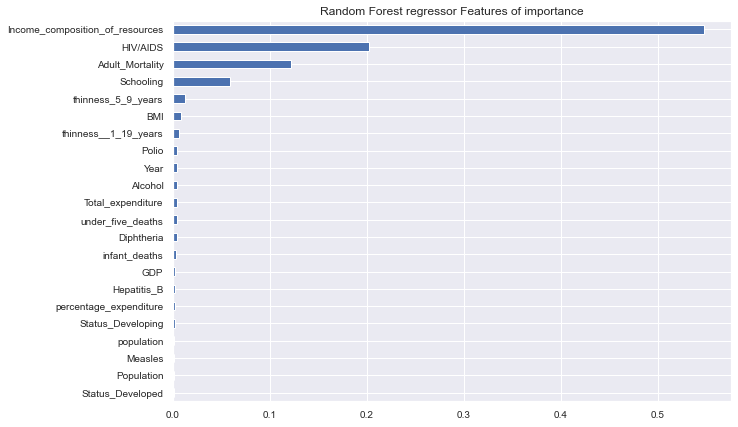

In [62]:
Important_features =  pd.Series(rf_reg4.feature_importances_, index = X_train.columns).sort_values()
Important_features.plot(kind='barh', figsize=(10,7) , fontsize=10)
plt.title('Random Forest regressor Features of importance')
plt.show()

In [63]:
# Perform K-Fold CV for Random forest regressor 
scores = cross_val_score(rf_reg4, X_train_imput_scale, y_train, cv= 5)

In [64]:
np.mean(scores)

0.9500902625279759

In [65]:
scores2 = cross_validate(rf_reg4, X_train_imput_scale, y_train, cv=5)

In [66]:
scores2 = cv_results['test_score']
np.mean(scores2), np.std(scores2)

(0.8793952573267643, 0.013289807859740158)

In [67]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 10)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 344, 488, 633, 777, 922, 1066, 1211, 1355, 1500], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False]}


In [68]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train_imput_scale, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=2)

In [69]:
rf_random.best_params_

{'n_estimators': 633,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.4,
 'max_depth': 40,
 'bootstrap': False}

In [70]:
rf_reg6 = rf_random.best_estimator_

In [71]:
predicted_train = rf_reg6.predict(X_train_imput_scale)
predicted_test = rf_reg6.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1024857703084279
MSE: 3.206293390522218
RMSE: 1.7906125740992154
R2 Square 0.9641899800942078
__________________________________
MAE: 4.297309756020651e-13
MSE: 3.0131734921725817e-25
RMSE: 5.489238100294595e-13
R2 Square 1.0
__________________________________


In [72]:
# Perform K-Fold CV
rf_scores = cross_val_score(rf_random.best_estimator_, X_train_imput_scale, y_train, cv=5)

In [73]:
 np.mean(rf_scores), np.std(rf_scores)

(0.9607251872557541, 0.0074507119423538465)

##### 1st Gradien Boosting Model 

In [74]:
grdB = GradientBoostingRegressor(n_estimators = 150, max_depth = 3, random_state=1)
grdB.fit(X_train_imput_scale, y_train)

GradientBoostingRegressor(n_estimators=150, random_state=1)

In [75]:
predicted_train = grdB.predict(X_train_imput_scale)
predicted_test = grdB.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.5439771100187263
MSE: 4.979547887326709
RMSE: 2.2314900598762946
R2 Square 0.9443850929256439
__________________________________
MAE: 1.1459256178294823
MSE: 2.581168057259521
RMSE: 1.6066013996195574
R2 Square 0.9716704762793804
__________________________________


#### 2nd Gradient Boost Model

In [76]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 150, num = 5)]
max_features =  [x for x in np.linspace(start = 0.2, stop = 1.0, num = 5)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [6, 8, 10, 12]
min_samples_leaf = [4, 6, 8, 10]
learning_rate = [x for x in np.linspace(0.01, 0.3, num = 5)]
criterion = ['mse',]


grd_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rate}
print(grd_grid)

{'n_estimators': [25, 56, 87, 118, 150], 'max_features': [0.2, 0.4, 0.6000000000000001, 0.8, 1.0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [6, 8, 10, 12], 'min_samples_leaf': [4, 6, 8, 10], 'learning_rate': [0.01, 0.08249999999999999, 0.155, 0.22749999999999998, 0.3]}


In [77]:
# with RandomizedSearchCV
grd = GradientBoostingRegressor()

grd_Boost = RandomizedSearchCV(estimator = grd, param_distributions= grd_grid,  cv = 5, verbose=1, random_state=1, n_jobs = -1)

In [78]:
# with GridSearchCV
grd = GradientBoostingRegressor(random_state = 1)

grd_Boost2 = GridSearchCV(estimator = grd, param_grid= grd_grid, scoring='neg_mean_squared_error', cv = 5, verbose=1, n_jobs = -1)

In [79]:
grd_Boost.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01,
                                                          0.08249999999999999,
                                                          0.155,
                                                          0.22749999999999998,
                                                          0.3],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': [0.2, 0.4,
                                                         0.6000000000000001,
                                                         0.8, 1.0],
                                        'min_samples_leaf': [4, 6, 8, 10],
                                        'min_samples_split': [6, 8, 10, 12],
                                        'n_estimators': [25, 56, 87, 1

In [80]:
grd_Boost2.fit(X_train_imput_scale, y_train)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.08249999999999999, 0.155,
                                           0.22749999999999998, 0.3],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.2, 0.4, 0.6000000000000001, 0.8,
                                          1.0],
                         'min_samples_leaf': [4, 6, 8, 10],
                         'min_samples_split': [6, 8, 10, 12],
                         'n_estimators': [25, 56, 87, 118, 150]},
             scoring='neg_mean_squared_error', verbose=1)

In [81]:
grd_Boost.best_params_

{'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

#grd_Boost.best_params_ = {'n_estimators': 118,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_features': 0.6000000000000001,
 'max_depth': 10,
 'learning_rate': 0.08249999999999999}

In [82]:
grd_Boost2.best_params_

{'learning_rate': 0.08249999999999999,
 'max_depth': 10,
 'max_features': 0.6000000000000001,
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'n_estimators': 150}

#grd_Boost2.best_params_ = {'learning_rate': 0.08249999999999999,
 'max_depth': 7,
 'max_features': 0.8,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 150}

In [83]:
grd_Boost.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=10, n_estimators=118)

In [84]:
grd_Boost2.best_estimator_

GradientBoostingRegressor(learning_rate=0.08249999999999999, max_depth=10,
                          max_features=0.6000000000000001, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=150,
                          random_state=1)

In [85]:
GRD_Boost= grd_Boost.best_estimator_

In [86]:
GRD_Boost2= grd_Boost2.best_estimator_

In [87]:
predicted_train = GRD_Boost.predict(X_train_imput_scale)
predicted_test = GRD_Boost.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.172784114418015
MSE: 3.4208974426571443
RMSE: 1.8495668256803117
R2 Square 0.9617931391184155
__________________________________
MAE: 0.19519841304237867
MSE: 0.11249779763613918
RMSE: 0.3354069135186977
R2 Square 0.9987652841829934
__________________________________


In [88]:
predicted_train = GRD_Boost2.predict(X_train_imput_scale)
predicted_test = GRD_Boost2.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.1706820830302334
MSE: 3.462588091881295
RMSE: 1.8608030771366686
R2 Square 0.9613275101828305
__________________________________
MAE: 0.14416879991134438
MSE: 0.05967600363504632
RMSE: 0.24428672423004555
R2 Square 0.9993450280171506
__________________________________


#### XGBoost regression model

In [89]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',  learning_rate= 0.04, max_depth=5,
                       n_estimators= 200, n_jobs=-1 )
xgbr.fit(X_train_imput_scale, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.04, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [90]:
predicted_train = xgbr.predict(X_train_imput_scale)
predicted_test = xgbr.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.375659246520649
MSE: 4.097322079660356
RMSE: 2.0241842998255755
R2 Square 0.9542383782885252
__________________________________
MAE: 0.8634313863565307
MSE: 1.4860088169722818
RMSE: 1.2190196130383963
R2 Square 0.9836903599085437
__________________________________


### 7. Mix of model, which model to select for ensemble model

In [91]:
alg= [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), 
      DecisionTreeRegressor(), LinearRegression(), SVR(), LassoCV()]

In [92]:
for i in alg:
    model= i
    model.fit(X_train_imput_scale, y_train)
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(i, model_eval(y_train, y_pred2))
    print("*"*50)
    print(i, model_eval(y_test, y_pred1))
    print("="*70)

MAE: 0.44462859931674015
MSE: 0.5088621132259642
RMSE: 0.7133457178857697
R2 Square 0.994415000888216
__________________________________
RandomForestRegressor() None
**************************************************
MAE: 1.2228919226393644
MSE: 3.664432102389078
RMSE: 1.91427064502099
R2 Square 0.9590731818498355
__________________________________
RandomForestRegressor() None
MAE: 2.342488876557018
MSE: 8.335391149694594
RMSE: 2.8871077481962106
R2 Square 0.9085151930995814
__________________________________
AdaBoostRegressor() None
**************************************************
MAE: 2.4254764349111233
MSE: 9.391604403201017
RMSE: 3.0645724666258123
R2 Square 0.8951083074243625
__________________________________
AdaBoostRegressor() None
MAE: 1.2688477169502397
MSE: 3.138630222141117
RMSE: 1.7716179673228416
R2 Square 0.9655520689254135
__________________________________
GradientBoostingRegressor() None
**************************************************
MAE: 1.5886525924401604
MSE:

### 7. Ensemble learning model  

In [93]:
# Train classifiers
reg1 = GradientBoostingRegressor(random_state=47)
reg2 = RandomForestRegressor(random_state=47)
reg3 = LinearRegression()

reg1.fit( X_train_imput_scale , y_train)
reg2.fit( X_train_imput_scale , y_train)
reg3.fit( X_train_imput_scale , y_train)

voting = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
voting.fit( X_train_imput_scale , y_train)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=47)),
                            ('rf', RandomForestRegressor(random_state=47)),
                            ('lr', LinearRegression())])

In [94]:
predicted_train = voting.predict(X_train_imput_scale)
predicted_test = voting.predict(X_test_imput_scale)
model_eval(y_test, predicted_test)
model_eval(y_train, predicted_train)

MAE: 1.5808207595023152
MSE: 5.260257234317124
RMSE: 2.2935250672964367
R2 Square 0.9412499439922422
__________________________________
MAE: 1.2560820940333515
MSE: 3.127921499560402
RMSE: 1.7685930847881324
R2 Square 0.9656696021520915
__________________________________


In [95]:
#voting.get_params()

### Selection of the best model

In [96]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

In [97]:
#GRD_Boost2

In [98]:
for model in models_liste[0:3]:
    model=model
    y_pred1= model.predict(X_test)
    y_pred2= model.predict(X_train)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)
for model in models_liste[3:]:
    model=model
    y_pred1= model.predict(X_test_imput_scale)
    y_pred2= model.predict(X_train_imput_scale)
    print(model)
    print('EVALUATION FOR TRAINING DATA SET')
    print(model_eval(y_train, y_pred2))
    print("*"*50)
    print('EVALUATION FOR TESTING DATA SET')    
    print(model_eval(y_test, y_pred1))
    print("="*70)

Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x00000207B801D940>)),
                ('linearregression', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 2.4352700808445658
MSE: 10.83356220337772
RMSE: 3.2914377106938724
R2 Square 0.8810966002170159
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 2.4212886816126575
MSE: 11.085552729009013
RMSE: 3.3294973688244616
R2 Square 0.8761891643896423
__________________________________
None
Pipeline(steps=[('iterativeimputer', IterativeImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=19)),
                ('linearregression', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 2.7194090026780766

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=47)),
                            ('rf', RandomForestRegressor(random_state=47)),
                            ('lr', LinearRegression())])
EVALUATION FOR TRAINING DATA SET
MAE: 1.2560820940333515
MSE: 3.127921499560402
RMSE: 1.7685930847881324
R2 Square 0.9656696021520915
__________________________________
None
**************************************************
EVALUATION FOR TESTING DATA SET
MAE: 1.5808207595023152
MSE: 5.260257234317124
RMSE: 2.2935250672964367
R2 Square 0.9412499439922422
__________________________________
None


In [99]:
def model_eval_dict(true, predicted, model_list, MAE, MSE, RMSE, R2):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    MAE.append(mae)
    MSE.append(mse)
    RMSE.append(rmse)
    R2.append(r2_square)
    return MAE, MSE, RMSE, R2

In [100]:
# evaluation  on train dataset

In [101]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

MAE = []
MSE = []
RMSE = []
R2 = []

for model in models_liste:
    if model in  models_liste[0:3]:
        y_pred2= model.predict(X_train)
        model_eval_dict(y_train, y_pred2, models_liste, MAE, MSE, RMSE, R2)   
    if model in models_liste[3:]:
        y_pred2= model.predict(X_train_imput_scale)
        model_eval_dict(y_train, y_pred2, models_liste, MAE, MSE, RMSE, R2)

In [102]:
# compute the dataframe with the value
models = ['linear_reg', 'linear_reg2', 'ridge_reg', 'Elastic_net', 'decision_tree', 'random_forest_reg1','random_forest_reg2', 'random_forest_reg3', 'random_forest_reg4',
               'gradien_boost_1','gradien_boost_2', 'gradien_boost_3', 'XGBRegressor', 'voting']
zipped = list(zip(models,models_liste,MAE, MSE, RMSE, R2))
df_r1 = pd.DataFrame(zipped, columns=['model','model_definition','MAE_tr', 'MSE_tr', 'RMSE_tr', 'R2_tr'])

In [103]:
df_r1

,model,model_definition,MAE_tr,MSE_tr,RMSE_tr,R2_tr
0,linear_reg,"(IterativeImputer(), StandardScaler(), SelectK...",2.435270,10.833562,3.291438,0.881097
1,linear_reg2,"(IterativeImputer(), StandardScaler(), PCA(n_c...",2.719409,12.856261,3.585563,0.858897
2,ridge_reg,"(IterativeImputer(), StandardScaler(), Ridge(a...",2.436159,10.830899,3.291033,0.881126
3,Elastic_net,"ElasticNet(alpha=0.0, l1_ratio=0.0)",2.434865,10.828913,3.290731,0.881148
4,decision_tree,"DecisionTreeRegressor(max_depth=4, max_feature...",3.867448,27.097628,5.205538,0.702591
5,random_forest_reg1,"(DecisionTreeRegressor(max_depth=4, max_featur...",1.965667,7.371328,2.715019,0.919096
6,random_forest_reg2,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.767292,1.245040,1.115814,0.986335
7,random_forest_reg3,"(DecisionTreeRegressor(max_depth=7, max_featur...",1.303094,3.295118,1.815246,0.963835
8,random_forest_reg4,"(DecisionTreeRegressor(max_depth=8, max_featur...",0.995858,2.030645,1.425007,0.977713
9,gradien_boost_1,([DecisionTreeRegressor(criterion='friedman_ms...,1.145926,2.581168,1.606601,0.971670


In [104]:
# evaluation  on test dataset

In [105]:
models_liste = [lin_reg, lin_reg2, ridge_reg, Elastic_net, model_dt, rf_reg1, rf_reg2, rf_reg3, rf_reg4,
               grdB, GRD_Boost,GRD_Boost2, xgbr, voting]

MAE = []
MSE = []
RMSE = []
R2 = []

for model in models_liste:
    if model in  models_liste[0:3]:
        y_pred1= model.predict(X_test)
        model_eval_dict(y_test, y_pred1, models_liste, MAE, MSE, RMSE, R2)
    
    if model in models_liste[3:]:
        y_pred1= model.predict(X_test_imput_scale)
        model_eval_dict(y_test, y_pred1, models_liste, MAE, MSE, RMSE, R2)

In [106]:
zipped = list(zip(MAE, MSE, RMSE, R2))
df_r2 = pd.DataFrame(zipped, columns=['MAE_tt', 'MSE_tt', 'RMSE_tt', 'R2_tt'])

In [107]:
df_r2

,MAE_tt,MSE_tt,RMSE_tt,R2_tt
0,2.421289,11.085553,3.329497,0.876189
1,2.675249,12.880212,3.588901,0.856145
2,2.419507,11.080546,3.328745,0.876245
3,2.420697,11.090842,3.330292,0.876130
4,3.863533,27.570816,5.250792,0.692071
5,2.070012,8.310519,2.882797,0.907183
6,1.351391,4.041962,2.010463,0.954857
7,1.612866,5.335103,2.309784,0.940414
8,1.444552,4.469658,2.114157,0.950080
9,1.543977,4.979548,2.231490,0.944385


In [108]:
# concat the two dataframe (test and train score of all metric)
results = pd.concat([df_r1, df_r2], axis=1)
results

,model,model_definition,MAE_tr,MSE_tr,RMSE_tr,R2_tr,MAE_tt,MSE_tt,RMSE_tt,R2_tt
0,linear_reg,"(IterativeImputer(), StandardScaler(), SelectK...",2.435270,10.833562,3.291438,0.881097,2.421289,11.085553,3.329497,0.876189
1,linear_reg2,"(IterativeImputer(), StandardScaler(), PCA(n_c...",2.719409,12.856261,3.585563,0.858897,2.675249,12.880212,3.588901,0.856145
2,ridge_reg,"(IterativeImputer(), StandardScaler(), Ridge(a...",2.436159,10.830899,3.291033,0.881126,2.419507,11.080546,3.328745,0.876245
3,Elastic_net,"ElasticNet(alpha=0.0, l1_ratio=0.0)",2.434865,10.828913,3.290731,0.881148,2.420697,11.090842,3.330292,0.876130
4,decision_tree,"DecisionTreeRegressor(max_depth=4, max_feature...",3.867448,27.097628,5.205538,0.702591,3.863533,27.570816,5.250792,0.692071
5,random_forest_reg1,"(DecisionTreeRegressor(max_depth=4, max_featur...",1.965667,7.371328,2.715019,0.919096,2.070012,8.310519,2.882797,0.907183
6,random_forest_reg2,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.767292,1.245040,1.115814,0.986335,1.351391,4.041962,2.010463,0.954857
7,random_forest_reg3,"(DecisionTreeRegressor(max_depth=7, max_featur...",1.303094,3.295118,1.815246,0.963835,1.612866,5.335103,2.309784,0.940414
8,random_forest_reg4,"(DecisionTreeRegressor(max_depth=8, max_featur...",0.995858,2.030645,1.425007,0.977713,1.444552,4.469658,2.114157,0.950080
9,gradien_boost_1,([DecisionTreeRegressor(criterion='friedman_ms...,1.145926,2.581168,1.606601,0.971670,1.543977,4.979548,2.231490,0.944385


In [109]:
#data_Zero_NAN # Raw data -- replace 0 with NaN---- delete 10 row 
datapath = '../data'
save_file(results, 'metrics_results_models.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\metrics_results_models.csv"


In [110]:
datapath = '../data'
save_file(coef_features, 'coef_features.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\coef_features.csv"
